In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import pearsonr

## Data Exploration

In [3]:
# loading in data
df = pd.read_csv("train.csv")

# dropping necessary columns to avoid data leakage
df = df[['ask_size', 
         'imbalance_size', 
         'matched_size',
         'bid_size',
         'reference_price']]

df['bid_ask_ratio'] = df['bid_size']/df['ask_size']

df.head()

,ask_size,imbalance_size,matched_size,bid_size,reference_price,bid_ask_ratio
0,8493.03,3180602.69,13380276.64,60651.50,0.999812,7.141326
1,20605.09,166603.91,1642214.25,3233.04,0.999896,0.156905
2,18995.00,302879.87,1819368.03,37956.00,0.999561,1.998210
3,479032.40,11917682.27,18389745.62,2324.90,1.000171,0.004853
4,434.10,447549.96,17860614.95,16485.54,0.999532,37.976365


To better understand the data we are working with, we beign by plotting the correlation of each predictor with one another

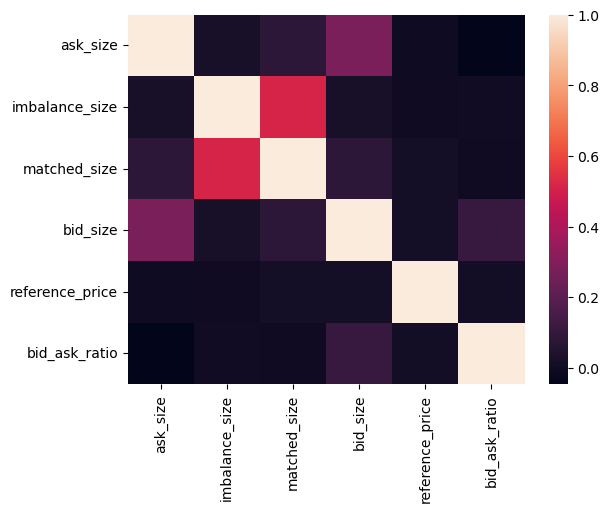

In [4]:
# isolating numerical values
num_vals = df
# starting by removing NaN values from dataset
# we can try some more complex methods later on
num_vals = num_vals.dropna()

# creating heatmap
corr_plot = sns.heatmap(num_vals.corr())

In [5]:
num_vals.corr()

,ask_size,imbalance_size,matched_size,bid_size,reference_price,bid_ask_ratio
ask_size,1.000000,0.022623,0.079209,0.278326,-0.006528,-0.046666
imbalance_size,0.022623,1.000000,0.512367,0.021141,-0.003717,-0.000928
matched_size,0.079209,0.512367,1.000000,0.078554,0.007724,-0.003421
bid_size,0.278326,0.021141,0.078554,1.000000,0.007271,0.106981
reference_price,-0.006528,-0.003717,0.007724,0.007271,1.000000,0.005937
bid_ask_ratio,-0.046666,-0.000928,-0.003421,0.106981,0.005937,1.000000


In our plot, we noticed some high correlations betweeen:
- near price & reference price: 0.47
- imbalance_buy_sell_flag & reference price: 0.51
- imbalance size & matched size: 0.51

Looking at the correlation heatmap, it is very obvious that we need to do some feature selection on this data when constructing our models. Also, as expected, Target had no correlations with ANY of the features (otherwise there would be no Kaggle competition to begin with).

To begin with we create a simple linear model using the full feature space to act as our baseline

## Baseline Model

The respone is super tight around 1. Seems like we will need to normalize the data so that we can actually use it for our analysis

In [6]:
# creating test-train split
X = num_vals.drop(["reference_price"], axis = 1)

# created response variable array
y = num_vals["reference_price"]

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2)

In [7]:
# creating model with fit
lmod = LinearRegression()
lmod.fit(X_tr,y_tr)

LinearRegression()

In [8]:
# generating predictions
y_hat = lmod.predict(X_tst)

# finding rmse of the baseline model
rmse_baseline = np.sqrt(mean_squared_error(y_tst, y_hat))
print(rmse_baseline)

0.0025280979595302764


Text(0.5, 1.0, 'Linear Regression Predicted Reference Price vs Actual')

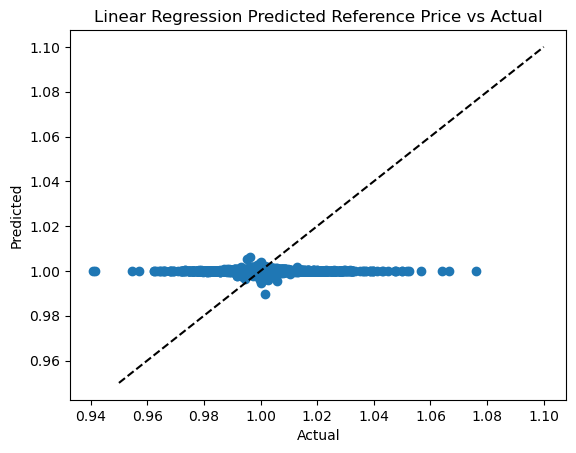

In [25]:
plt.plot(y_tst, y_hat, linestyle="None", marker = "o")
plt.plot(np.linspace(0.95,1.1, 10), np.linspace(0.95,1.1, 10), 
         color = "black", linestyle = "--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Predicted Reference Price vs Actual")

In [21]:
# creating feature selection model
bes = SequentialFeatureSelector(LinearRegression(), 
                                direction="forward")

# perfoming model fit
bes.fit(X_tr, y_tr)

# printing optimal feat
pred_bet_feature_set = bes.get_feature_names_out()
print(pred_bet_feature_set)

['matched_size']


In [22]:
X_tr = X_tr[pred_bet_feature_set]
X_tst = X_tst[pred_bet_feature_set]

lmod = LinearRegression()

lmod.fit(X_tr,y_tr)

lmod_preds = lmod.predict(X_tst)

# rmse with removed features
rmse_subset = np.sqrt(mean_squared_error(y_tst, lmod_preds))
print(rmse_subset)

0.0025284441746599696


In [23]:
mae = np.abs(sum(lmod_preds - y_tst))/len(y_tst)
print(mae)

4.179277173697584e-06


In [24]:
pearsonr(lmod_preds,y_tst)[0]

0.006284727473093384

Looking at the RMSE we see above, it appears as though removing these features does not cause any significant increase in the RMSE. Although based on earlier correlation plots, it seems as though more features can be removed from the data.